In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import random
import tqdm  # For progress display
import numpy as np

torch.backends.cudnn.benchmark = True

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])

# Custom Dataset for Siamese Network
class SiameseNetworkDataset(Dataset):
    def __init__(self, imageFolderDataset, transform=None):
        self.imageFolderDataset = imageFolderDataset
        self.transform = transform
        self.classes = self.imageFolderDataset.classes
        self.class_to_idx = self.imageFolderDataset.class_to_idx
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        self.image_paths = self.imageFolderDataset.imgs

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        # Get an image and its label
        img0_tuple = self.image_paths[index]
        img0_path, label0 = img0_tuple

        # Decide whether to make a positive or negative pair
        should_get_same_class = random.randint(0, 1)

        if should_get_same_class:
            # Keep looping till a different image of the same class is found
            while True:
                idx = random.randint(0, len(self.image_paths) - 1)
                img1_tuple = self.image_paths[idx]
                img1_path, label1 = img1_tuple
                if label0 == label1 and img0_path != img1_path:
                    break
        else:
            # Keep looping till an image of a different class is found
            while True:
                idx = random.randint(0, len(self.image_paths) - 1)
                img1_tuple = self.image_paths[idx]
                img1_path, label1 = img1_tuple
                if label0 != label1:
                    break

        # Load images
        img0 = Image.open(img0_path).convert("RGB")
        img1 = Image.open(img1_path).convert("RGB")

        if self.transform:
            img0 = self.transform(img0)
            img1 = self.transform(img1)

        # Label is 0 if same class, 1 if different class
        label = torch.tensor([int(label0 != label1)], dtype=torch.float32)

        return img0, img1, label

# Path to your dataset
data_dir = 'imgs'  # Replace with your dataset path

# Create the dataset and dataloader
image_folder_dataset = datasets.ImageFolder(root=data_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=image_folder_dataset,
                                        transform=data_transforms)

train_loader = DataLoader(
    siamese_dataset,
    shuffle=True,
    batch_size=8,   # Increase batch size if GPU memory allows
)

# Define the Siamese Network using ResNet50
class SiameseNetwork_resnet50(nn.Module):
    def __init__(self):
        super(SiameseNetwork_resnet50, self).__init__()
        # Load pretrained ResNet50
        self.model = models.resnet50(pretrained=True)
        # Modify the last layer to output embeddings of size 256
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 256)

    def forward_once(self, x):
        output = self.model(x)
        return output

    def forward(self, input1, input2):
        # Pass both inputs through the network
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2




import torch.nn as nn
from torchvision import models

# Define the Siamese Network using VGG16
class SiameseNetwork_vgg16(nn.Module):
    def __init__(self):
        super(SiameseNetwork_vgg16, self).__init__()
        # Load pretrained VGG16
        self.model = models.vgg16(pretrained=True)
        # Modify the classifier to output embeddings of size 256
        num_ftrs = self.model.classifier[6].in_features
        self.model.classifier[6] = nn.Linear(num_ftrs, 256)
    
    def forward_once(self, x):
        output = self.model(x)
        return output

    def forward(self, input1, input2):
        # Pass both inputs through the network
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2



# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    """
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        # Compute Euclidean distance between output1 and output2
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        # Compute the contrastive loss
        loss_contrastive = torch.mean(
            (1 - label) * torch.pow(euclidean_distance, 2) +
            (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2)
        )
        return loss_contrastive

# Initialize the network, criterion, and optimizer
net = SiameseNetwork_vgg16()

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


net.to(device)

criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.00001)




from timeit import default_timer as timer

start = timer()

ll = []

num_epochs = 10
for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        img0, img1, label = data
        img0, img1, label = img0.to(device), img1.to(device), label.to(device)
        optimizer.zero_grad()
        output1, output2 = net(img0, img1)
        loss = criterion(output1, output2, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {i}, Loss {loss.item():.4f}")
            ll.append(loss.item())
    print(f"Epoch {epoch+1} completed, Average Loss: {running_loss/len(train_loader):.4f}")
    torch.save(net.state_dict(), 'siamese_vgg16_'+str(epoch)+'.pth')

end = timer()
print(end - start)



/home/stefan/miniconda3/envs/similify/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/10, Batch 0, Loss 54.7438
Epoch 1/10, Batch 10, Loss 14.5117
Epoch 1/10, Batch 20, Loss 6.6123
Epoch 1/10, Batch 30, Loss 2.7671
Epoch 1/10, Batch 40, Loss 1.3708
Epoch 1/10, Batch 50, Loss 1.0785
Epoch 1/10, Batch 60, Loss 0.4507
Epoch 1/10, Batch 70, Loss 1.1937
Epoch 1/10, Batch 80, Loss 1.0044
Epoch 1/10, Batch 90, Loss 1.1988
Epoch 1/10, Batch 100, Loss 1.3082
Epoch 1/10, Batch 110, Loss 1.0392
Epoch 1/10, Batch 120, Loss 1.0235
Epoch 1/10, Batch 130, Loss 1.1345
Epoch 1/10, Batch 140, Loss 0.9411
Epoch 1/10, Batch 150, Loss 0.9913
Epoch 1/10, Batch 160, Loss 1.0126
Epoch 1/10, Batch 170, Loss 1.0605
Epoch 1/10, Batch 180, Loss 1.0452
Epoch 1/10, Batch 190, Loss 1.0189
Epoch 1/10, Batch 200, Loss 1.0374
Epoch 1/10, Batch 210, Loss 0.9946
Epoch 1/10, Batch 220, Loss 0.9967
Epoch 1/10, Batch 230, Loss 1.0579
Epoch 1/10, Batch 240, Loss 1.0356
Epoch 1/10, Batch 250, Loss 1.0101
Epoch 1/10, Batch 260, Loss 1.0244
Epoch 1/10, Batch 270, Loss 0.9799
Epoch 1/10, Batch 280, Loss 1

In [2]:
net = SiameseNetwork_vgg16()

# Specify the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net.to(device)

# Load the saved state dictionary
net.load_state_dict(torch.load('siamese_vgg16_3.pth', map_location=device))

# Set the model to evaluation mode
net.eval()

C:\Users\Stefan\AppData\Local\Temp\ipykernel_20772\3438666181.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('siamese_vgg16_3.pth', map_l

SiameseNetwork_vgg16(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])

# Load CIFAR-10 dataset
cifar10_dataset = datasets.ImageFolder(root='imgs', transform=transform)
batch_size = 16  # Adjust batch size based on GPU memory
data_loader = DataLoader(cifar10_dataset, batch_size=batch_size, shuffle=False)




In [12]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import tqdm  # For progress display
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

def extract_features_batch(dataloader, model):
    features_db = []
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for images, _ in tqdm.tqdm(dataloader, desc="Extracting Features"):
            images = images.to(device)  # Move batch of images to device
            batch_features = model.forward_once(images)  # Get features for batch
            batch_features = batch_features.cpu().numpy()  # Move to CPU and convert to numpy
            features_db.append(batch_features)

    # Stack all features into a single array
    return np.vstack(features_db)

def extract_features(image):
    with torch.no_grad():
        features = net.forward_once(image)
        features = features.cpu().numpy().flatten()  # Move to CPU and convert to numpy
        return features


def find_similar_images(query_image_path, features_db, top_n=10):
    

    
    query_image = Image.open(query_image_path).convert('RGB')
    query_image = transform(query_image)
    query_image = query_image.to(device)  # Move query image to device
    query_features = extract_features(query_image.unsqueeze(0))  # Extract features for query image


    nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine').fit(features_db)
    distances, indices = nbrs.kneighbors(query_features.reshape(1, -1), n_neighbors=10)
    distances = distances[0]
    indices = indices[0] 
    
    most_similar_indices = indices[:48]
    distances = distances[:48]

    similar_images = [(cifar10_dataset.imgs[idx], 1 - distances[i]) for i, idx in enumerate(most_similar_indices)]
    
    return similar_images

In [5]:
features_db = extract_features_batch(data_loader, net)

Extracting Features: 100%|███████████████████████████████████████████████████████████| 658/658 [01:13<00:00,  8.95it/s]


In [6]:
np.save("features_vgg_contrastive.npy",features_db)

Rank 1, Similarity: 1.0


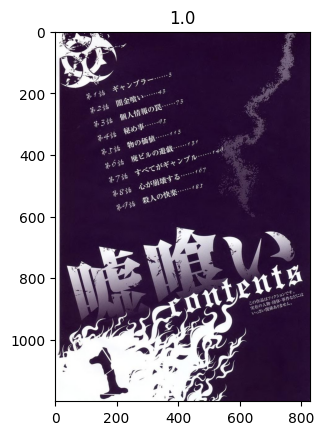

Rank 2, Similarity: 0.9744689464569092


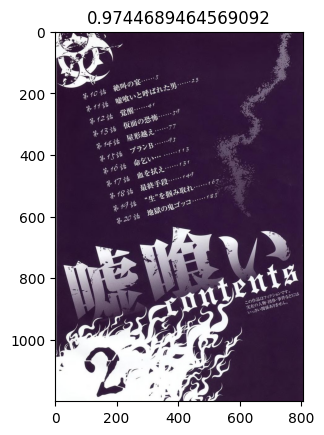

Rank 3, Similarity: 0.812921404838562


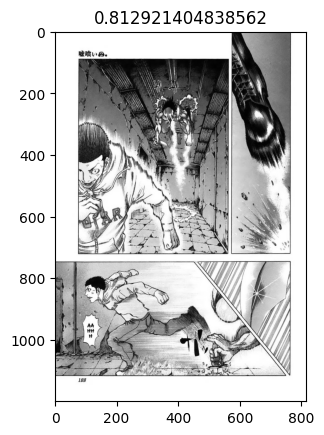

Rank 4, Similarity: 0.8054407835006714


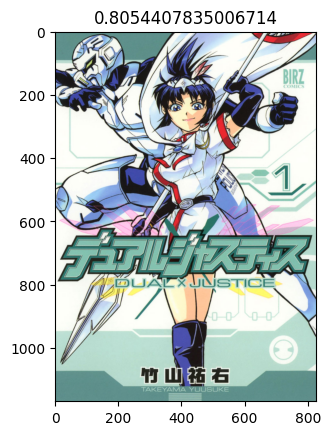

Rank 5, Similarity: 0.7926883101463318


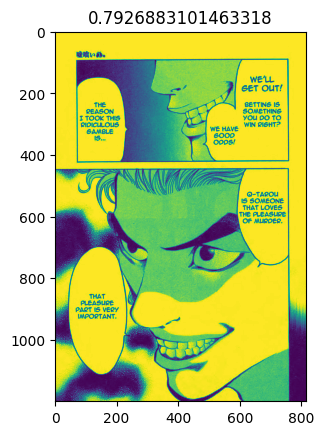

Rank 6, Similarity: 0.783382773399353


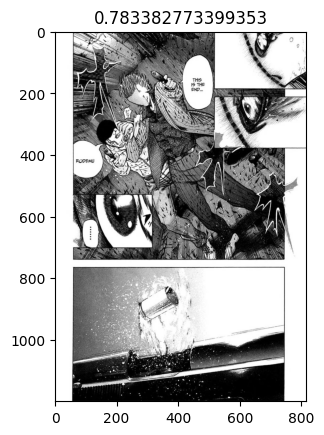

Rank 7, Similarity: 0.782514214515686


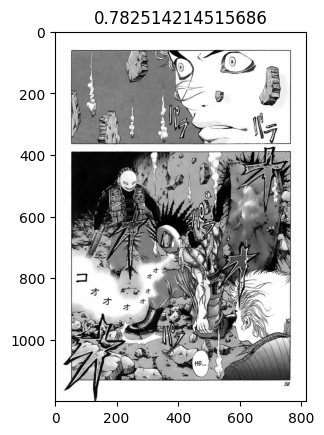

Rank 8, Similarity: 0.7818537354469299


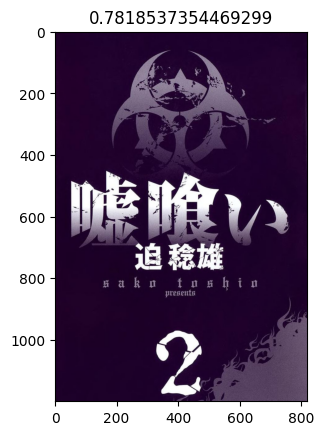

Rank 9, Similarity: 0.7808692455291748


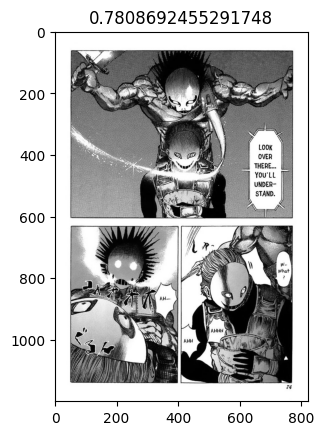

Rank 10, Similarity: 0.7725185751914978


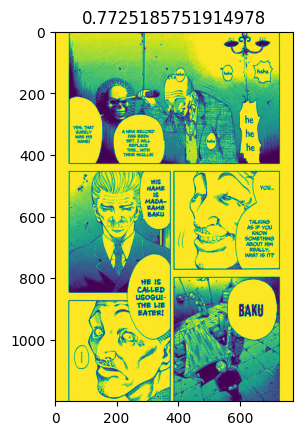

In [13]:

query_image_path = 'imgs/11/v01_0005.jpg'  # Replace with the actual path to the user-provided image
similar_images = find_similar_images(query_image_path, features_db)

# # # Display results
for i, (image_data, similarity) in enumerate(similar_images):
    print(f"Rank {i+1}, Similarity: {similarity}")

     # Convert CIFAR-10 image array to PIL image and display
    original_image = Image.open(image_data[0])
    plt.imshow(original_image)
    plt.title(similarity)
    plt.show()

CPU times: total: 10.8 s
Wall time: 1.48 s


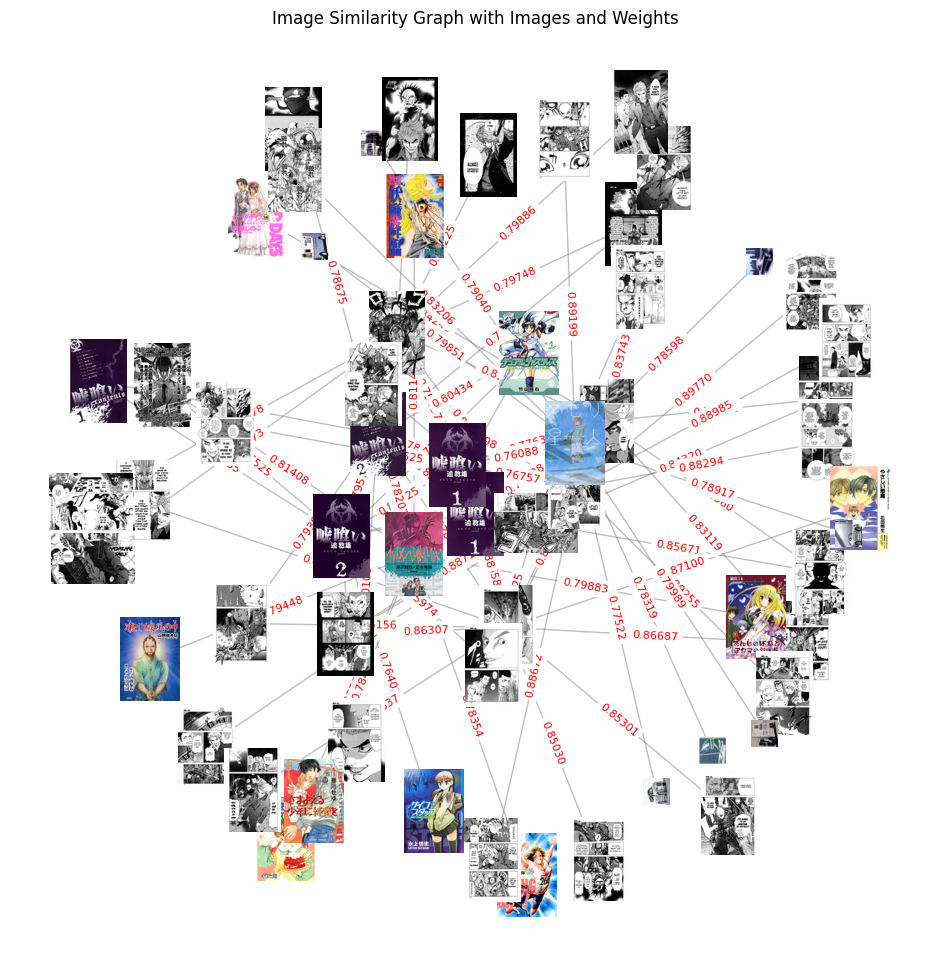

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_graph_with_images_and_weights(G):
    pos = nx.spring_layout(G, k=0.8)
    plt.figure(figsize=(12, 12))
    ax = plt.gca()

    # Draw edges with constant width
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=1)

    # For each node, place the image at its position
    for node in G.nodes():
        x, y = pos[node]
        # Load and resize the image
        try:
            img = Image.open(node).convert('RGB')
        except FileNotFoundError:
            print(f"Image not found: {node}")
            continue
        img.thumbnail((100, 100), Image.LANCZOS)
        # Create an OffsetImage
        imagebox = OffsetImage(img)
        # Adjust the zoom level if needed
        imagebox = OffsetImage(img, zoom=0.6)
        # Create an AnnotationBbox and add it to the plot
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    # Prepare edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    # Format the weights to have up to 2 decimal places
    formatted_edge_labels = {edge: f"{weight:.5f}" for edge, weight in edge_labels.items()}

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_color='red', font_size=8)

    # Remove axes and display the plot
    plt.axis('off')
    plt.title("Image Similarity Graph with Images and Weights")
    plt.show()

# Call the function to visualize the graph
visualize_graph_with_images_and_weights(G)


Image: imgs/11/v01_0003.jpg, Estimated Probability: 0.2472


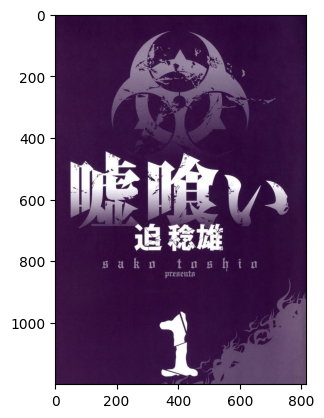

Image: imgs\12\v02_0005.jpg, Estimated Probability: 0.0582


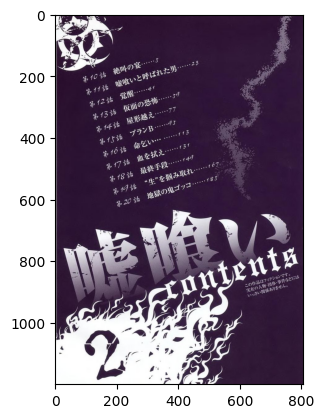

Image: imgs\11\v01_0003.jpg, Estimated Probability: 0.0564


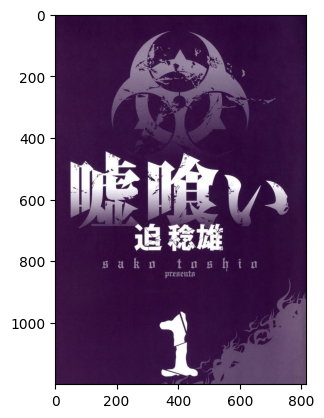

Image: imgs\10\PrayerHaNemurenai.png, Estimated Probability: 0.0536


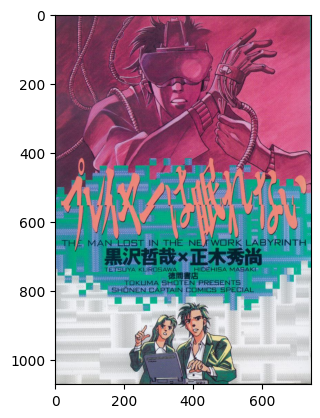

Image: imgs\12\v02_0056.jpg, Estimated Probability: 0.0526


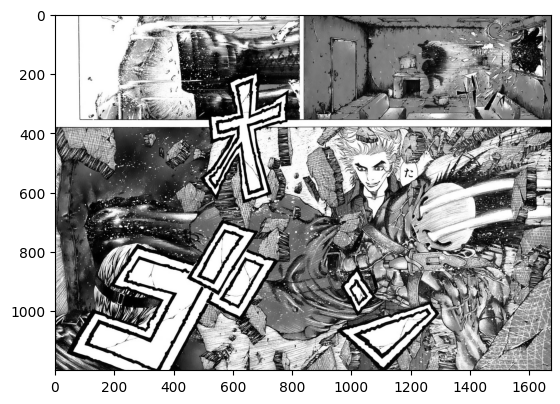

Image: imgs\12\v02_0108.jpg, Estimated Probability: 0.0526


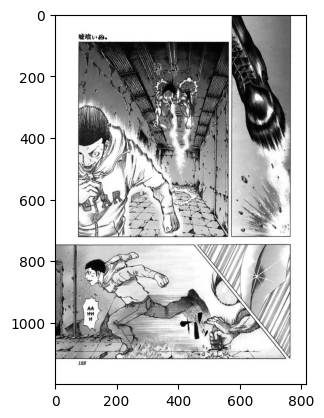

Image: imgs\12\v02_0003.jpg, Estimated Probability: 0.052


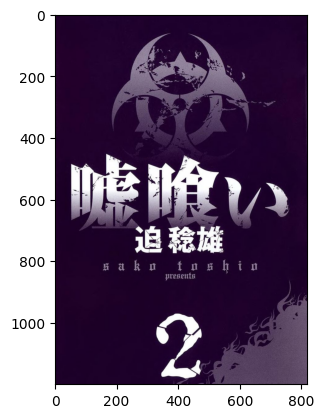

Image: imgs\12\v02_0048.jpg, Estimated Probability: 0.0478


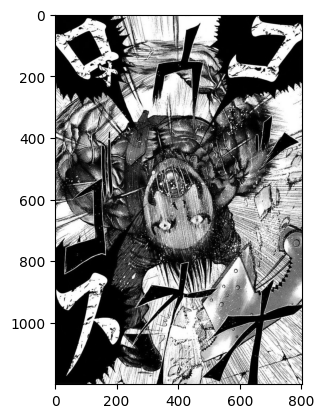

Image: imgs\11\v01_0012.jpg, Estimated Probability: 0.0476


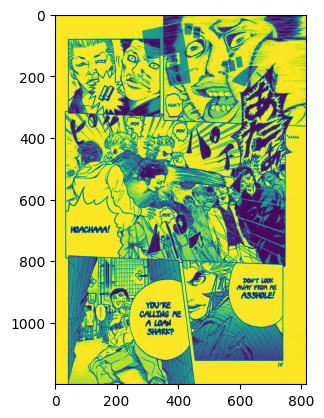

Image: imgs\11\v01_0094.jpg, Estimated Probability: 0.0452


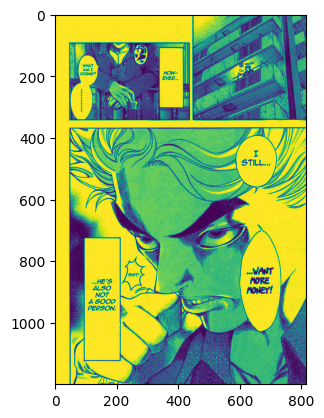

In [25]:
import numpy as np
import networkx as nx
from collections import defaultdict
import random

def stochastic_diffusion_process(G, query_image_path, num_steps=10, reset_prob=0.01, num_walks=1000):

    # Ensure the query image is in the graph
    if query_image_path not in G:
        raise ValueError("Query image path not found in the graph.")

    # Precompute cumulative distribution functions (CDFs) for neighbors
    neighbor_cdfs = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            weights = np.array([G[node][nbr].get('weight', 1.0) for nbr in neighbors])
            total_weight = weights.sum()
            probabilities = weights / total_weight
            cdf = np.cumsum(probabilities)
            neighbor_cdfs[node] = (neighbors, cdf)

    # Initialize a counter for visits to each node
    visit_counts = defaultdict(int)

    # Simulate random walks
    for walk in range(num_walks):
        current_node = query_image_path
        for step in range(num_steps):
            # Reset to query image with reset probability
            if random.random() < reset_prob:
                current_node = query_image_path

            # Record visit to current node
            visit_counts[current_node] += 1

            # Check if the current node has neighbors
            if current_node in neighbor_cdfs:
                neighbors, cdf = neighbor_cdfs[current_node]
                rnd = random.random()
                # Select the next node based on the CDF
                idx = np.searchsorted(cdf, rnd)
                current_node = neighbors[idx]
            else:
                # If no neighbors, stay in the current node
                continue

    # Calculate probabilities by normalizing visit counts
    total_visits = sum(visit_counts.values())
    node_probabilities = {node: count / total_visits for node, count in visit_counts.items()}

    return node_probabilities

# Usage example
num_steps = 5
reset_prob = 0.01  # 1% probability to reset to the query image at each step
num_walks = 1000  # Number of random walks to simulate
node_probabilities = stochastic_diffusion_process(
    G,
    query_image_path,
    num_steps=num_steps,
    reset_prob=reset_prob,
    num_walks=num_walks
)

# Get top 10 images by estimated probability after diffusion
sorted_nodes = sorted(node_probabilities.items(), key=lambda x: x[1], reverse=True)
top_images = sorted_nodes[:10]

# Print the top images and their probabilities
for image_path, prob in top_images:
    print(f"Image: {image_path}, Estimated Probability: {prob}")
    original_image = Image.open(image_path)
    plt.imshow(original_image)
    plt.show()

In [ ]:
for i, (image_data, similarity) in enumerate(similar_images):
    print(f"Rank {i+1}, Similarity: {similarity}")

     # Convert CIFAR-10 image array to PIL image and display
    original_image = Image.open(image_data[0])
    plt.imshow(original_image)
    plt.title(similarity)
    plt.show()

In [3]:
from flask import Flask, request, render_template, redirect, url_for
from flask_socketio import SocketIO, emit
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import io
import base64
from torch.utils.data import DataLoader
import tqdm  # For progress display
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from utils import FeatureExtractorResNet,FeatureExtractorVGG,FeatureExtractorResNetContrastive,FeatureExtractorVggContrastive


# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Transformation applied to all images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])


# Load CIFAR-10 dataset
cifar10_dataset = datasets.ImageFolder(root='imgs', transform=transform)



# Load both models and their feature databases
# ResNet50 model and features
resnet_model = FeatureExtractorResNet()
resnet_model = resnet_model.to(device)
resnet_model.eval()
features_resnet50 = np.load('features_resnet50.npy')

# VGG16 model and features
vgg_model = FeatureExtractorVGG()
vgg_model = vgg_model.to(device)
vgg_model.eval()
features_vgg16 = np.load('features_vgg16.npy')

# # ResNet50 contrastive model and features
# resnet_contrastive_model = FeatureExtractorResNetContrastive()
# resnet_contrastive_model = resnet_contrastive_model.to(device)
# resnet_contrastive_model.eval()
# resnet_contrastive_model.load_state_dict(torch.load('siamese_resnet50.pth', map_location=device))
# features_resnet_contrastive = np.load('features_resnet50_contrastive.npy')

# # VGG16 contrastive model and features
# vgg_contrastive_model = FeatureExtractorVggContrastive()
# vgg_contrastive_model = vgg_contrastive_model.to(device)
# vgg_contrastive_model.eval()
# vgg_contrastive_model.load_state_dict(torch.load('siamese_vgg16_3.pth', map_location=device))
# features_vgg_contrastive = np.load('features_vgg_contrastive.npy')

C:\Users\Stefan\anaconda3\envs\similify\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Stefan\anaconda3\envs\similify\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Stefan\anaconda3\envs\similify\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_

In [4]:
def find_similar_images(query_features, features_db, metric):
    # Compute similarities/distances based on the selected metric
    if metric == 'cosine':

        nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine').fit(features_db)
        distances, indices = nbrs.kneighbors(query_features.reshape(1, -1), n_neighbors=10)
        
        distances = distances[0]
        indices = indices[0] 

        similar_images = [(cifar10_dataset.imgs[idx], 1 - distances[i]) for i, idx in enumerate(indices)]
    else:
        # For distance metrics, lower values mean more similar
        if metric == 'euclidean':
            nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='euclidean').fit(features_db)
            distances, indices = nbrs.kneighbors(query_features.reshape(1, -1), n_neighbors=10)
        elif metric == 'manhattan':
            nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='manhattan').fit(features_db)
            distances, indices = nbrs.kneighbors(query_features.reshape(1, -1), n_neighbors=10)


        distances = distances[0]
        indices = indices[0] 
        
        similar_images = [(cifar10_dataset.imgs[idx], distances[i]) for i, idx in enumerate(indices)]

    return similar_images

In [5]:
# Updated extract_features 
def extract_features(image, model):
    with torch.no_grad():
        features = model(image)
        features = features.cpu().numpy().flatten()  # Move to CPU and convert to numpy

        return features

In [31]:
%%time
import numpy as np
from PIL import Image
import networkx as nx



def build_similarity_graph(query_image_path, depth, N,metric,model):
    G = nx.Graph()
    visited = set()
    queue = [(query_image_path, 0)]  # (image_path, current_depth)
    while queue:
        current_image_path, current_depth = queue.pop(0)  # BFS
        if current_depth >= depth:
            continue
        if current_image_path in visited:
            continue
        visited.add(current_image_path)


        if model == 'resnet50':
            query_image = Image.open(query_image_path).convert('RGB')
            query_image_tensor = transform(query_image).unsqueeze(0).to(device)
            query_features_resnet = extract_features(query_image_tensor, resnet_model)
        
            similar_images = find_similar_images(query_features_resnet, features_resnet50,metric)



        if model == 'vgg16':
            query_image = Image.open(query_image_path).convert('RGB')
            query_image_tensor = transform(query_image).unsqueeze(0).to(device)
            query_features_vgg = extract_features(query_image_tensor, vgg_model)
        
            similar_images = find_similar_images(query_features_vgg, features_vgg16,metric)

        # Exclude the current image from similar_images
        similar_images = [sim_img for sim_img in similar_images if sim_img[0][0] != current_image_path]

        if not similar_images:
            continue  # Skip if no similar images found

        # Normalize similarities and add edges
        for similar_image in similar_images:
            similar_image_path = similar_image[0][0]
            # Add edge to the graph with normalized weight
            G.add_edge(current_image_path, similar_image_path, weight=similar_image[1])
            queue.append((similar_image_path, current_depth + 1))
    return G

CPU times: total: 0 ns
Wall time: 0 ns


In [40]:
from collections import defaultdict
import random
def stochastic_diffusion_process(G, query_image_path, num_steps=10, reset_prob=0.01, num_walks=1000):

    # Ensure the query image is in the graph
    if query_image_path not in G:
        raise ValueError("Query image path not found in the graph.")

    # Precompute cumulative distribution functions (CDFs) for neighbors
    neighbor_cdfs = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            weights = np.array([G[node][nbr].get('weight', 1.0) for nbr in neighbors])
            total_weight = weights.sum()
            probabilities = weights / total_weight
            cdf = np.cumsum(probabilities)
            neighbor_cdfs[node] = (neighbors, cdf)

    # Initialize a counter for visits to each node
    visit_counts = defaultdict(int)

    # Simulate random walks
    for walk in range(num_walks):
        current_node = query_image_path
        for step in range(num_steps):
            # Reset to query image with reset probability
            if random.random() < reset_prob:
                current_node = query_image_path

            # Record visit to current node
            visit_counts[current_node] += 1

            # Check if the current node has neighbors
            if current_node in neighbor_cdfs:
                neighbors, cdf = neighbor_cdfs[current_node]
                rnd = random.random()
                # Select the next node based on the CDF
                idx = np.searchsorted(cdf, rnd)
                current_node = neighbors[idx]
            else:
                # If no neighbors, stay in the current node
                continue

    # Calculate probabilities by normalizing visit counts
    total_visits = sum(visit_counts.values())
    node_probabilities = {node: count / total_visits for node, count in visit_counts.items()}

    return node_probabilities

# Usage example


In [49]:
metric = 'cosine'
graph = 1
model = 'resnet'
    # Load the query image
query_image_path = "uploads/istockphoto-155439315-612x612.jpg"
query_image = Image.open(query_image_path).convert('RGB')
query_image_tensor = transform(query_image).unsqueeze(0).to(device)
if graph == 0:
            # Extract features using both models
    query_features_resnet = extract_features(query_image_tensor, resnet_model)
    query_features_vgg = extract_features(query_image_tensor, vgg_model)
    # query_features_resnet_contrastive = extract_features(query_image_tensor, resnet_contrastive_model)
    # query_features_vgg_contrastive = extract_features(query_image_tensor, vgg_contrastive_model)
    
        
        # Find similar images for both models
    similar_images_resnet = find_similar_images(query_features_resnet, features_resnet50, metric)
    similar_images_vgg = find_similar_images(query_features_vgg, features_vgg16, metric)
    # similar_images_resnet_contrastive = find_similar_images(query_features_resnet_contrastive, features_resnet_contrastive, metric)
    # similar_images_vgg_contrastive = find_similar_images(query_features_vgg_contrastive, features_vgg_contrastive, metric)
if graph == 1:
    G_resnet = build_similarity_graph(query_image_path, depth=3, N=5,metric=metric,model='resnet50')
    G_vgg = build_similarity_graph(query_image_path, depth=3, N=5,metric=metric,model='vgg16')
    num_steps = 5
    reset_prob = 0.01  # 1% probability to reset to the query image at each step
    num_walks = 100  # Number of random walks to simulate
    
    node_probabilities_resnet = stochastic_diffusion_process(
    G_resnet,
    query_image_path,
    num_steps=num_steps,
    reset_prob=reset_prob,
    num_walks=num_walks)


    sorted_nodes_resnet = sorted(node_probabilities_resnet.items(), key=lambda x: x[1], reverse=True)
    similar_images_resnet = sorted_nodes_resnet[:10]



    node_probabilities_vgg = stochastic_diffusion_process(
    G_vgg,
    query_image_path,
    num_steps=num_steps,
    reset_prob=reset_prob,
    num_walks=num_walks)


    sorted_nodes_vgg = sorted(node_probabilities_vgg.items(), key=lambda x: x[1], reverse=True)
    similar_images_vgg = sorted_nodes_vgg[:10]




Image: uploads/istockphoto-155439315-612x612.jpg, Estimated Probability: 0.254


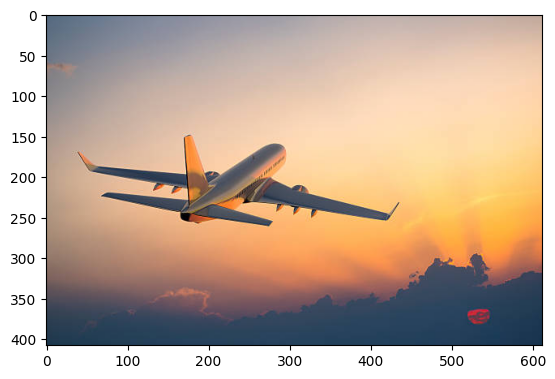

Image: imgs\0\3445.jpg, Estimated Probability: 0.094


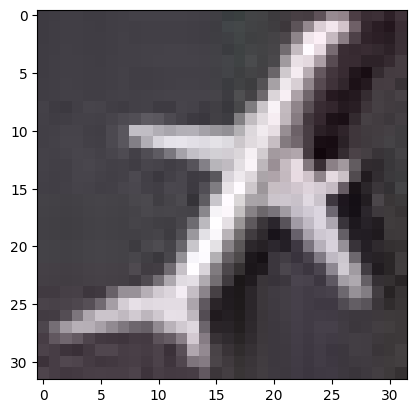

Image: imgs\0\8543.jpg, Estimated Probability: 0.092


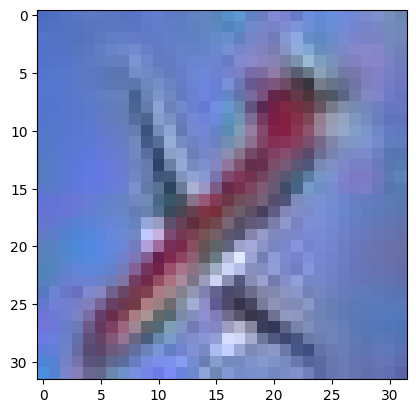

Image: imgs\0\4419.jpg, Estimated Probability: 0.088


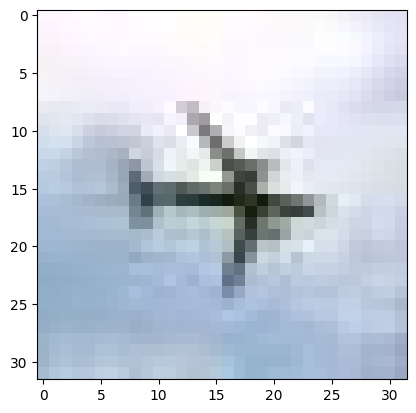

Image: imgs\0\3499.jpg, Estimated Probability: 0.078


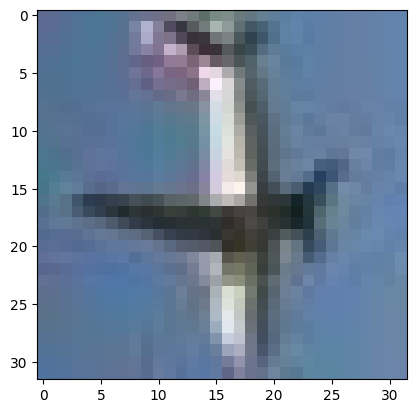

Image: imgs\0\6508.jpg, Estimated Probability: 0.076


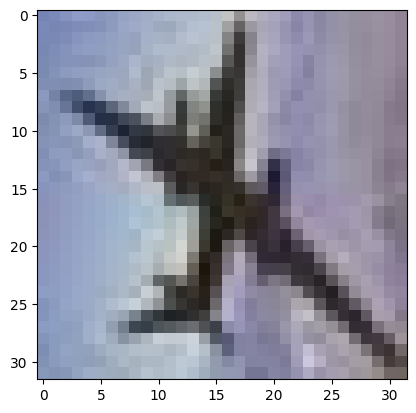

Image: imgs\0\9473.jpg, Estimated Probability: 0.07


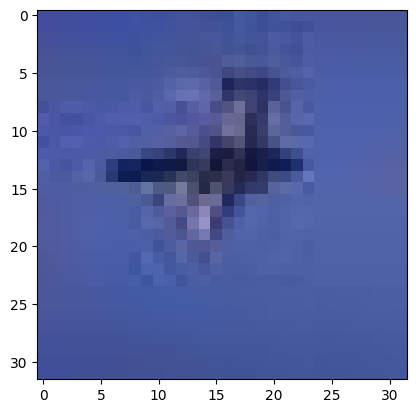

Image: imgs\0\3927.jpg, Estimated Probability: 0.07


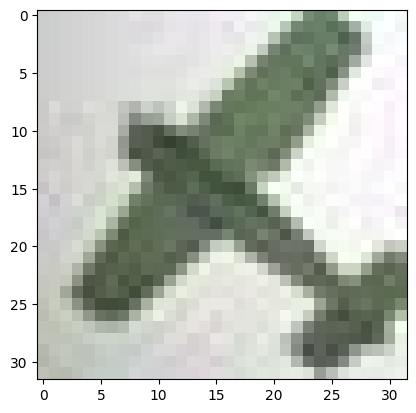

Image: imgs\0\6437.jpg, Estimated Probability: 0.066


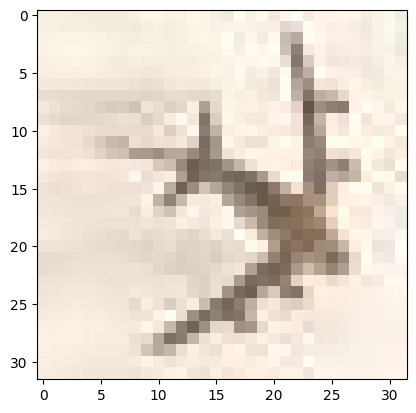

Image: imgs\0\5091.jpg, Estimated Probability: 0.066


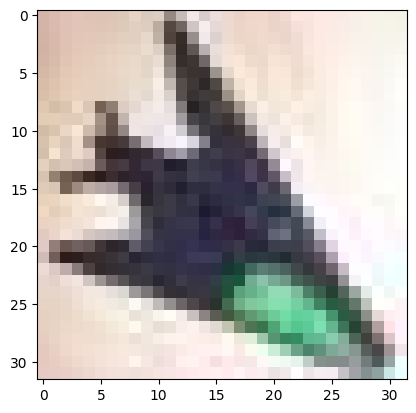

In [50]:
for image_path, prob in top_images_resnet:
    print(f"Image: {image_path}, Estimated Probability: {prob}")
    original_image = Image.open(image_path)
    plt.imshow(original_image)
    plt.show()

Image: uploads/istockphoto-155439315-612x612.jpg, Estimated Probability: 0.246


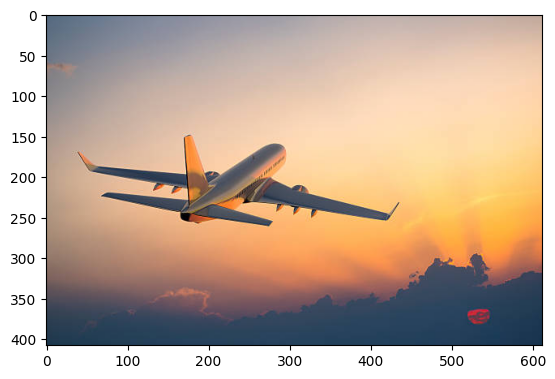

Image: imgs\0\1365.jpg, Estimated Probability: 0.092


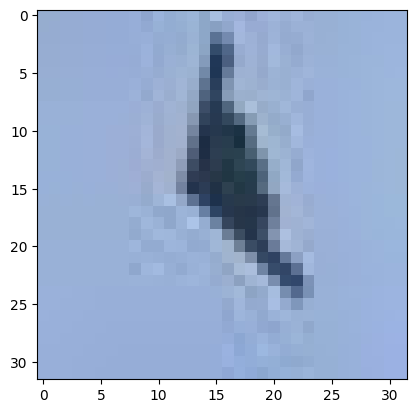

Image: imgs\0\1875.jpg, Estimated Probability: 0.088


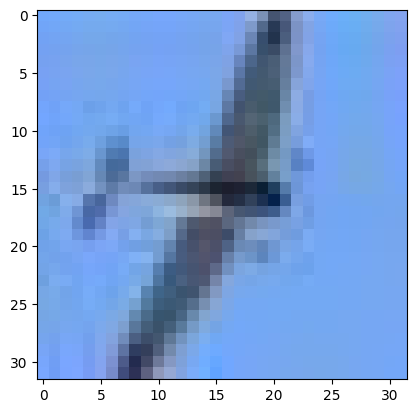

Image: imgs\0\5968.jpg, Estimated Probability: 0.082


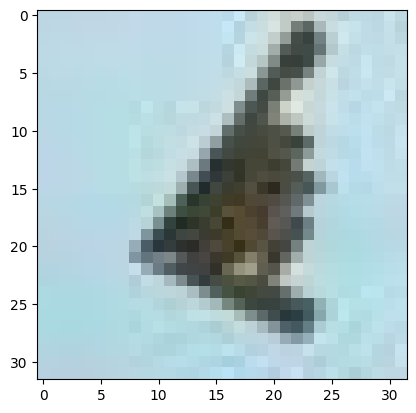

Image: imgs\0\9017.jpg, Estimated Probability: 0.078


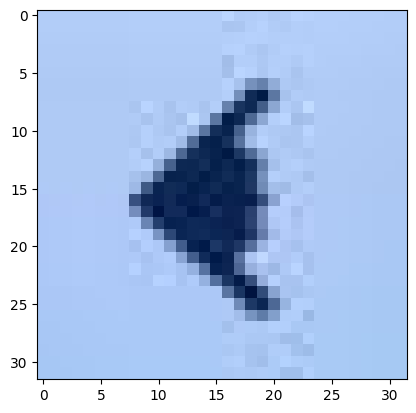

Image: imgs\0\9354.jpg, Estimated Probability: 0.074


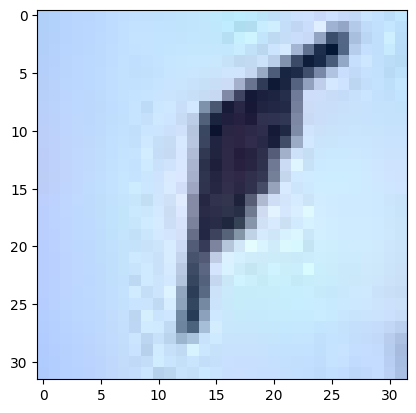

Image: imgs\0\8800.jpg, Estimated Probability: 0.074


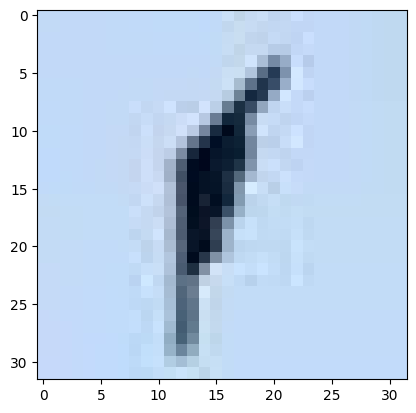

Image: imgs\0\6331.jpg, Estimated Probability: 0.07


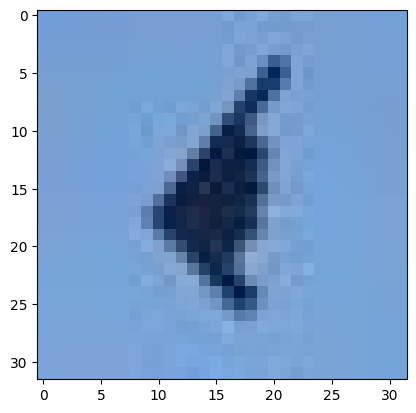

Image: imgs\0\3248.jpg, Estimated Probability: 0.068


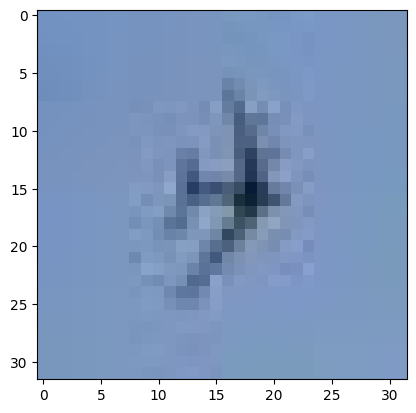

Image: imgs\0\2468.jpg, Estimated Probability: 0.068


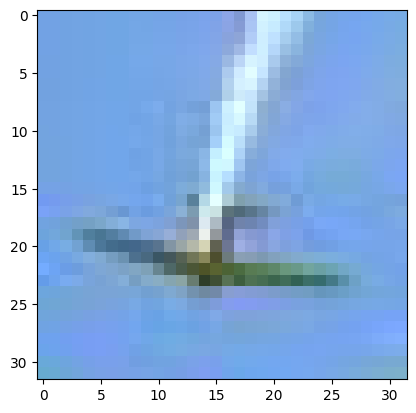

In [51]:
for image_path, prob in top_images_vgg:
    print(f"Image: {image_path}, Estimated Probability: {prob}")
    original_image = Image.open(image_path)
    plt.imshow(original_image)
    plt.show()

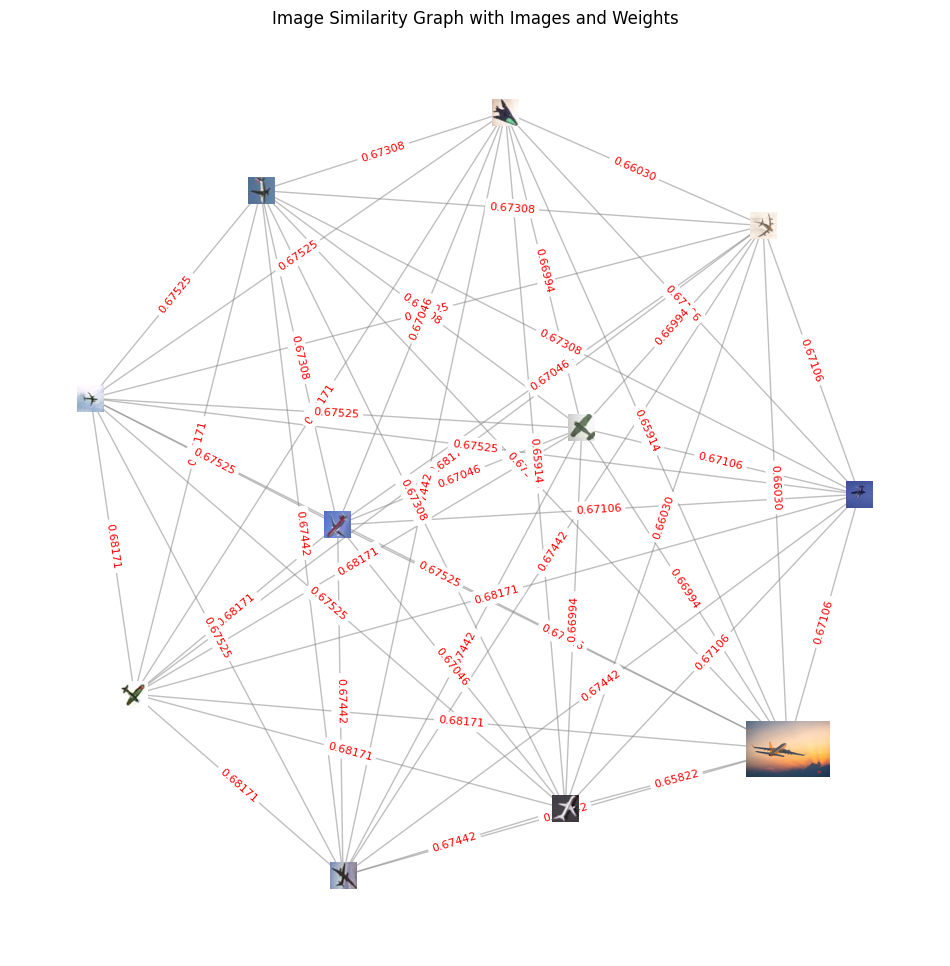

In [38]:
import matplotlib.pyplot as plt
import networkx as nx
from PIL import Image
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def visualize_graph_with_images_and_weights(G):
    pos = nx.spring_layout(G, k=0.8)
    plt.figure(figsize=(12, 12))
    ax = plt.gca()

    # Draw edges with constant width
    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, width=1)

    # For each node, place the image at its position
    for node in G.nodes():
        x, y = pos[node]
        # Load and resize the image
        try:
            img = Image.open(node).convert('RGB')
        except FileNotFoundError:
            print(f"Image not found: {node}")
            continue
        img.thumbnail((100, 100), Image.LANCZOS)
        # Create an OffsetImage
        imagebox = OffsetImage(img)
        # Adjust the zoom level if needed
        imagebox = OffsetImage(img, zoom=0.6)
        # Create an AnnotationBbox and add it to the plot
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

    # Prepare edge labels (weights)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    # Format the weights to have up to 2 decimal places
    formatted_edge_labels = {edge: f"{weight:.5f}" for edge, weight in edge_labels.items()}

    # Draw edge labels
    nx.draw_networkx_edge_labels(G, pos, edge_labels=formatted_edge_labels, font_color='red', font_size=8)

    # Remove axes and display the plot
    plt.axis('off')
    plt.title("Image Similarity Graph with Images and Weights")
    plt.show()

# Call the function to visualize the graph
visualize_graph_with_images_and_weights(G_resnet)


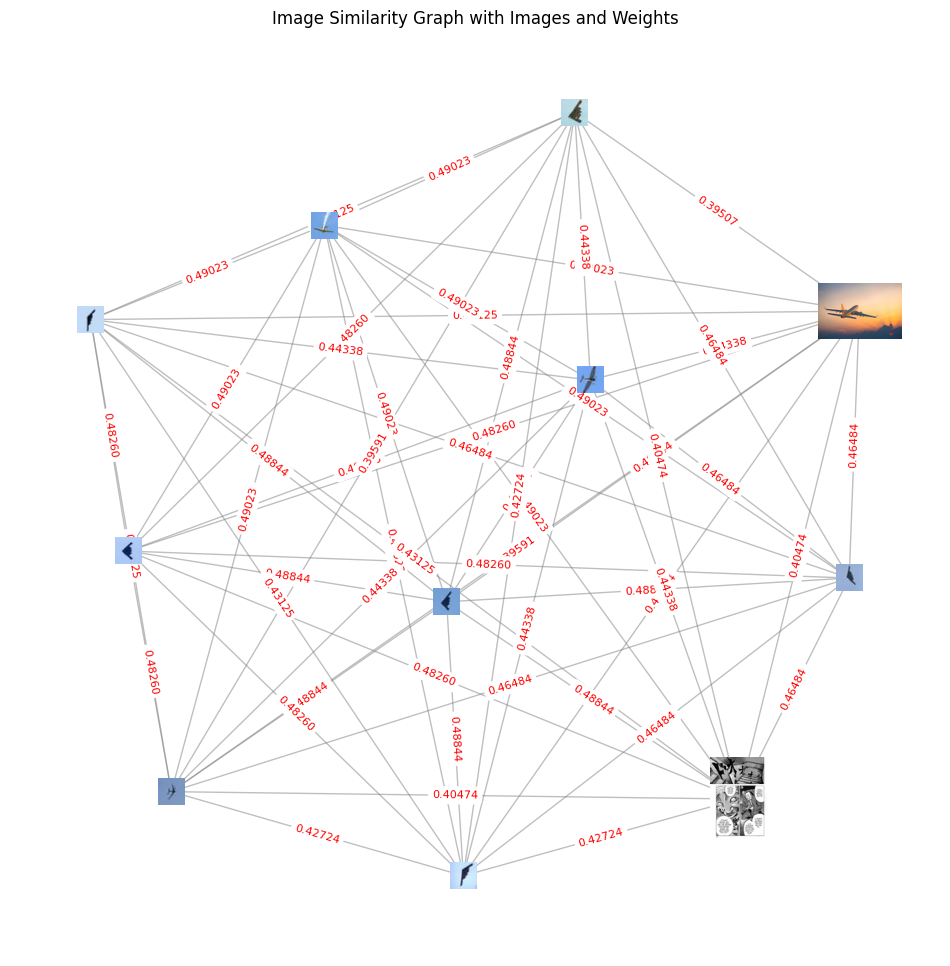

In [35]:
visualize_graph_with_images_and_weights(G_vgg)

In [52]:
from flask import Flask, request, render_template, redirect, url_for
from flask_socketio import SocketIO, emit
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
import torchvision.datasets as datasets
from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
import io
import base64
from torch.utils.data import DataLoader
import tqdm  # For progress display
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors
from utils import FeatureExtractorResNet,FeatureExtractorVGG,FeatureExtractorResNetContrastive,FeatureExtractorVggContrastive

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Transformation applied to all images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 for models
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for pretrained models
])


# Load CIFAR-10 dataset
cifar10_dataset = datasets.ImageFolder(root='imgs', transform=transform)



# Load both models and their feature databases
# ResNet50 model and features
resnet_model = FeatureExtractorResNet()
resnet_model = resnet_model.to(device)
resnet_model.eval()
features_resnet50 = np.load('features_resnet50.npy')

# VGG16 model and features
vgg_model = FeatureExtractorVGG()
vgg_model = vgg_model.to(device)
vgg_model.eval()
features_vgg16 = np.load('features_vgg16.npy')

# ResNet50 contrastive model and features
resnet_contrastive_model = FeatureExtractorResNetContrastive()
resnet_contrastive_model = resnet_contrastive_model.to(device)
resnet_contrastive_model.eval()
resnet_contrastive_model.load_state_dict(torch.load('siamese_resnet50.pth', map_location=device))
features_resnet_contrastive = np.load('features_resnet50_contrastive.npy')

# VGG16 contrastive model and features
vgg_contrastive_model = FeatureExtractorVggContrastive()
vgg_contrastive_model = vgg_contrastive_model.to(device)
vgg_contrastive_model.eval()
vgg_contrastive_model.load_state_dict(torch.load('siamese_vgg16_3.pth', map_location=device))
features_vgg_contrastive = np.load('features_vgg_contrastive.npy')



# Function to find most similar images using selected similarity metric
def find_similar_images(query_features, features_db, metric):
    # Compute similarities/distances based on the selected metric
    if metric == 'cosine':

        nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='cosine').fit(features_db)
        distances, indices = nbrs.kneighbors(query_features.reshape(1, -1), n_neighbors=10)
        
        distances = distances[0]
        indices = indices[0] 

        similar_images = [(cifar10_dataset.imgs[idx], 1 - distances[i]) for i, idx in enumerate(indices)]
    else:
        # For distance metrics, lower values mean more similar
        if metric == 'euclidean':
            nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='euclidean').fit(features_db)
            distances, indices = nbrs.kneighbors(query_features.reshape(1, -1), n_neighbors=10)
        elif metric == 'manhattan':
            nbrs = NearestNeighbors(n_neighbors=10, algorithm='auto', metric='manhattan').fit(features_db)
            distances, indices = nbrs.kneighbors(query_features.reshape(1, -1), n_neighbors=10)


        distances = distances[0]
        indices = indices[0] 
        
        similar_images = [(cifar10_dataset.imgs[idx], distances[i]) for i, idx in enumerate(indices)]

    return similar_images




import numpy as np
from PIL import Image
import networkx as nx



def build_similarity_graph(query_image_path, depth, N,metric,model):
    G = nx.Graph()
    visited = set()
    queue = [(query_image_path, 0)]  # (image_path, current_depth)
    while queue:
        current_image_path, current_depth = queue.pop(0)  # BFS
        if current_depth >= depth:
            continue
        if current_image_path in visited:
            continue
        visited.add(current_image_path)


        if model == 'resnet50':
            query_image = Image.open(query_image_path).convert('RGB')
            query_image_tensor = transform(query_image).unsqueeze(0).to(device)
            query_features_resnet = extract_features(query_image_tensor, resnet_model)
        
            similar_images = find_similar_images(query_features_resnet, features_resnet50,metric)



        if model == 'vgg16':
            query_image = Image.open(query_image_path).convert('RGB')
            query_image_tensor = transform(query_image).unsqueeze(0).to(device)
            query_features_vgg = extract_features(query_image_tensor, vgg_model)
        
            similar_images = find_similar_images(query_features_vgg, features_vgg16,metric)

        # Exclude the current image from similar_images
        similar_images = [sim_img for sim_img in similar_images if sim_img[0][0] != current_image_path]

        if not similar_images:
            continue  # Skip if no similar images found

        # Normalize similarities and add edges
        for similar_image in similar_images:
            similar_image_path = similar_image[0][0]
            # Add edge to the graph with normalized weight
            G.add_edge(current_image_path, similar_image_path, weight=similar_image[1])
            queue.append((similar_image_path, current_depth + 1))
    return G



from collections import defaultdict
import random
def stochastic_diffusion_process(G, query_image_path, num_steps=10, reset_prob=0.01, num_walks=1000):

    # Ensure the query image is in the graph
    if query_image_path not in G:
        raise ValueError("Query image path not found in the graph.")

    # Precompute cumulative distribution functions (CDFs) for neighbors
    neighbor_cdfs = {}
    for node in G.nodes():
        neighbors = list(G.neighbors(node))
        if neighbors:
            weights = np.array([G[node][nbr].get('weight', 1.0) for nbr in neighbors])
            total_weight = weights.sum()
            probabilities = weights / total_weight
            cdf = np.cumsum(probabilities)
            neighbor_cdfs[node] = (neighbors, cdf)

    # Initialize a counter for visits to each node
    visit_counts = defaultdict(int)

    # Simulate random walks
    for walk in range(num_walks):
        current_node = query_image_path
        for step in range(num_steps):
            # Reset to query image with reset probability
            if random.random() < reset_prob:
                current_node = query_image_path

            # Record visit to current node
            visit_counts[current_node] += 1

            # Check if the current node has neighbors
            if current_node in neighbor_cdfs:
                neighbors, cdf = neighbor_cdfs[current_node]
                rnd = random.random()
                # Select the next node based on the CDF
                idx = np.searchsorted(cdf, rnd)
                current_node = neighbors[idx]
            else:
                # If no neighbors, stay in the current node
                continue

    # Calculate probabilities by normalizing visit counts
    total_visits = sum(visit_counts.values())
    node_probabilities = {node: count / total_visits for node, count in visit_counts.items()}

    return node_probabilities

# Usage example


    
# Updated extract_features 
def extract_features(image, model):
    with torch.no_grad():
        features = model(image)
        features = features.cpu().numpy().flatten()  # Move to CPU and convert to numpy

        return features









C:\Users\Stefan\anaconda3\envs\similify\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Stefan\anaconda3\envs\similify\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Stefan\anaconda3\envs\similify\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_

In [53]:
    metric = 'cosine'
    filepath = 'uploads/istockphoto-155439315-612x612.jpg'
    graph = 1
    # Load the query image
    query_image = Image.open(filepath).convert('RGB')
    query_image_tensor = transform(query_image).unsqueeze(0).to(device)

    if graph == 0:
        # Extract features using both models
        query_features_resnet = extract_features(query_image_tensor, resnet_model)
        query_features_vgg = extract_features(query_image_tensor, vgg_model)
        query_features_resnet_contrastive = extract_features(query_image_tensor, resnet_contrastive_model)
        query_features_vgg_contrastive = extract_features(query_image_tensor, vgg_contrastive_model)
    
        
        # Find similar images for both models
        similar_images_resnet = find_similar_images(query_features_resnet, features_resnet50, metric)
        similar_images_vgg = find_similar_images(query_features_vgg, features_vgg16, metric)
        similar_images_resnet_contrastive = find_similar_images(query_features_resnet_contrastive, features_resnet_contrastive, metric)
        similar_images_vgg_contrastive = find_similar_images(query_features_vgg_contrastive, features_vgg_contrastive, metric)

    if graph == 1:
        G_resnet = build_similarity_graph(filepath, depth=3, N=5,metric=metric,model='resnet50')
        G_vgg = build_similarity_graph(filepath, depth=3, N=5,metric=metric,model='vgg16')
        num_steps = 5
        reset_prob = 0.01  # 1% probability to reset to the query image at each step
        num_walks = 100  # Number of random walks to simulate
        
        node_probabilities_resnet = stochastic_diffusion_process(
        G_resnet,
        filepath,
        num_steps=num_steps,
        reset_prob=reset_prob,
        num_walks=num_walks)
    
    
        sorted_nodes_resnet = sorted(node_probabilities_resnet.items(), key=lambda x: x[1], reverse=True)
        similar_images_resnet = sorted_nodes_resnet[:10]
    
        print(similar_images_resnet)
    
        node_probabilities_vgg = stochastic_diffusion_process(
        G_vgg,
        filepath,
        num_steps=num_steps,
        reset_prob=reset_prob,
        num_walks=num_walks)
    
    
        sorted_nodes_vgg = sorted(node_probabilities_vgg.items(), key=lambda x: x[1], reverse=True)
        similar_images_vgg = sorted_nodes_vgg[:10]

        print(similar_images_vgg)

        
    
    # Convert images to base64 and include their filenames
    images_resnet = []
    for img_array, similarity in similar_images_resnet:
        img = Image.open(img_array[0])
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        images_resnet.append({
            'img_data': img_str,
            'similarity': f"{similarity:.4f}",
            'name': os.path.basename(img_array[0])  # Include file name
        })

    images_vgg = []
    for img_array, similarity in similar_images_vgg:
        img = Image.open(img_array[0])
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        images_vgg.append({
            'img_data': img_str,
            'similarity': f"{similarity:.4f}",
            'name': os.path.basename(img_array[0])  # Include file name
        })

    images_resnet_contrastive = []
    for img_array, similarity in similar_images_resnet_contrastive:
        img = Image.open(img_array[0])
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        images_resnet_contrastive.append({
            'img_data': img_str,
            'similarity': f"{similarity:.4f}",
            'name': os.path.basename(img_array[0])  # Include file name
        })

    images_vgg_contrastive = []
    for img_array, similarity in similar_images_vgg_contrastive:
        img = Image.open(img_array[0])
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        images_vgg_contrastive.append({
            'img_data': img_str,
            'similarity': f"{similarity:.4f}",
            'name': os.path.basename(img_array[0])  # Include file name
        })

[('uploads/istockphoto-155439315-612x612.jpg', 0.256), ('imgs\\0\\6508.jpg', 0.094), ('imgs\\0\\3927.jpg', 0.092), ('imgs\\0\\3445.jpg', 0.088), ('imgs\\0\\9473.jpg', 0.074), ('imgs\\0\\4419.jpg', 0.07), ('imgs\\0\\5091.jpg', 0.068), ('imgs\\0\\8543.jpg', 0.068), ('imgs\\0\\6437.jpg', 0.068), ('imgs\\0\\3499.jpg', 0.062)]
[('uploads/istockphoto-155439315-612x612.jpg', 0.25), ('imgs\\0\\6331.jpg', 0.09), ('imgs\\0\\8800.jpg', 0.084), ('imgs\\0\\1365.jpg', 0.082), ('imgs\\0\\2468.jpg', 0.082), ('imgs\\0\\5968.jpg', 0.074), ('imgs\\0\\9354.jpg', 0.072), ('imgs\\11\\v01_0138.jpg', 0.07), ('imgs\\0\\3248.jpg', 0.07), ('imgs\\0\\9017.jpg', 0.066)]


FileNotFoundError: [Errno 2] No such file or directory: 'u'

In [56]:
    images_resnet = []
    for img_array, similarity in similar_images_resnet:
        # img = Image.open(img_array[0])
        print(img_array)

        

uploads/istockphoto-155439315-612x612.jpg
imgs\0\6508.jpg
imgs\0\3927.jpg
imgs\0\3445.jpg
imgs\0\9473.jpg
imgs\0\4419.jpg
imgs\0\5091.jpg
imgs\0\8543.jpg
imgs\0\6437.jpg
imgs\0\3499.jpg
